In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_iris
import pandas as pd
from numpy import unique

In [2]:
def label_to_one_hot(label):
    one_hot = [0, 0, 0]
    one_hot[label] = 1
    return one_hot


df_train = pd.read_csv("../data/train_embedded_bert.csv")
df_train["sentence_embedding"] = df_train["sentence_embedding"].apply(
    lambda x: np.array([float(value) for value in x[1:-1].split(",")]))

df_test = pd.read_csv("../data/test_embedded_bert.csv")
df_test["sentence_embedding"] = df_test["sentence_embedding"].apply(
    lambda x: np.array([float(value) for value in x[1:-1].split(",")]))

df_train["yhot"] = df_train["label"].apply(label_to_one_hot)

X_train = np.zeros(shape=(len(df_train), 768))
for i in range(len(df_train)):
    X_train[i] = df_train["sentence_embedding"].values[i]

X_test = np.zeros(shape=(len(df_test), 768))
for i in range(len(df_test)):
    X_test[i] = df_test["sentence_embedding"].values[i]

Y_train = np.zeros(shape=(len(df_train), 3))
for i in range(len(df_train)):
    Y_train[i] = df_train["yhot"].values[i]
Y_train = Y_train.astype(int)

In [3]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [5]:
x_train_train, x_train_test, y_train_train, y_train_test = train_test_split(X_train, Y_train, test_size=0.15)

In [42]:
def make_cnn():
    model = Sequential()
    model.add(Conv1D(filters=4,
                     kernel_size=2,
                     activation="relu",
                     input_shape=(1, 768)))
    model.add(Dense(units=16,
                    activation="relu"))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(units=3,
                    activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy'])
    print(model.summary())
    return model

In [41]:
model = make_cnn()

ValueError: Exception encountered when calling layer "conv1d_8" (type Conv1D).

Negative dimension size caused by subtracting 2 from 1 for '{{node conv1d_8/Conv1D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](conv1d_8/Conv1D/ExpandDims, conv1d_8/Conv1D/ExpandDims_1)' with input shapes: [?,1,1,768], [1,2,768,1].

Call arguments received:
  • inputs=tf.Tensor(shape=(None, 1, 768), dtype=float32)

In [39]:
model.fit(x_train_test, y_train_test, batch_size=16, epochs=100, verbose=1)

Epoch 1/100


ValueError: in user code:

    File "/home/legmint/.local/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/home/legmint/.local/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/legmint/.local/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/home/legmint/.local/lib/python3.8/site-packages/keras/engine/training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "/home/legmint/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/legmint/.local/lib/python3.8/site-packages/keras/engine/input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_8" is incompatible with the layer: expected shape=(None, 4, 768), found shape=(None, 768, 1)


In [6]:
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Embedding,CuDNNLSTM,Bidirectional, Reshape, Conv2D, MaxPool2D, Concatenate, Flatten, MaxPool1D
import matplotlib.pyplot as plt

In [7]:
def cnn_bert(metric="accuracy",size_vector=768,):
    filter_sizes = [5, 50, 3]
    num_filters = 10
    drop = 0.9

    inputs = Input(shape=(size_vector, 1), dtype='float32')
    conv_0 = Conv1D(num_filters, kernel_size=filter_sizes[0], padding='valid', kernel_initializer='normal',
                    activation='relu')(inputs)
    maxpool_0 = MaxPool1D(pool_size=2, padding='same')(conv_0)
    flatten = Flatten()(maxpool_0)
    dropout = Dropout(drop)(flatten)
    output = Dense(units=3, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[metric])
    return model

In [26]:
def train_plot_cnn(x_train, y_train, metric="accuracy", batch_size = 64, epochs = 200):
    model = cnn_bert(metric)
    history = model.fit(x_train, y_train, validation_split=0.15, batch_size=batch_size, epochs=epochs, verbose=True)
    # list all data in history
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history[metric.lower()], c="blue", label="train")
    plt.plot(history.history['val_'+metric.lower()], c="orange", label="test")
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'], c="blue", label="train")
    plt.plot(history.history['val_loss'], c="orange", label="test")
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    return model, history

Epoch 1/100
161/161 [==============================] - 1s 7ms/step - loss: 1.1055 - auc: 0.5107 - val_loss: 1.0961 - val_auc: 0.5482
Epoch 2/100
161/161 [==============================] - 1s 6ms/step - loss: 1.0982 - auc: 0.5161 - val_loss: 1.0954 - val_auc: 0.5487
Epoch 3/100
161/161 [==============================] - 1s 6ms/step - loss: 1.0977 - auc: 0.5185 - val_loss: 1.0947 - val_auc: 0.5583
Epoch 4/100
161/161 [==============================] - 1s 6ms/step - loss: 1.0971 - auc: 0.5247 - val_loss: 1.0936 - val_auc: 0.5655
Epoch 5/100
161/161 [==============================] - 1s 6ms/step - loss: 1.0970 - auc: 0.5236 - val_loss: 1.0934 - val_auc: 0.5640
Epoch 6/100
161/161 [==============================] - 1s 6ms/step - loss: 1.0963 - auc: 0.5268 - val_loss: 1.0917 - val_auc: 0.5634
Epoch 7/100
161/161 [==============================] - 1s 6ms/step - loss: 1.0963 - auc: 0.5300 - val_loss: 1.0908 - val_auc: 0.5689
Epoch 8/100
161/161 [==============================] - 1s 6ms/step - 

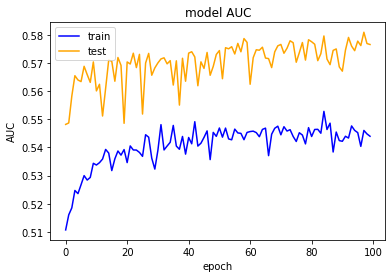

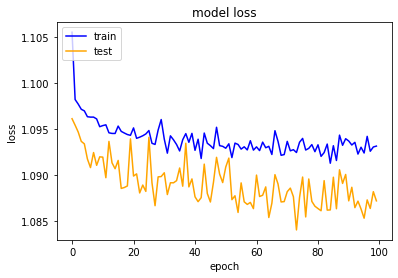

In [29]:
model_auc,history_auc = train_plot_cnn(x_train=X_train,
                           y_train=Y_train,
                           metric='AUC',
                           batch_size=64,
                           epochs=100)

Epoch 1/100
161/161 [==============================] - 1s 7ms/step - loss: 1.1096 - accuracy: 0.3316 - val_loss: 1.0951 - val_accuracy: 0.3630
Epoch 2/100
161/161 [==============================] - 1s 6ms/step - loss: 1.0990 - accuracy: 0.3401 - val_loss: 1.0953 - val_accuracy: 0.3465
Epoch 3/100
161/161 [==============================] - 1s 6ms/step - loss: 1.0978 - accuracy: 0.3493 - val_loss: 1.0958 - val_accuracy: 0.3834
Epoch 4/100
161/161 [==============================] - 1s 6ms/step - loss: 1.0970 - accuracy: 0.3528 - val_loss: 1.0962 - val_accuracy: 0.3680
Epoch 5/100
161/161 [==============================] - 1s 6ms/step - loss: 1.0965 - accuracy: 0.3460 - val_loss: 1.0924 - val_accuracy: 0.3779
Epoch 6/100
161/161 [==============================] - 1s 6ms/step - loss: 1.0961 - accuracy: 0.3580 - val_loss: 1.0930 - val_accuracy: 0.4004
Epoch 7/100
161/161 [==============================] - 1s 6ms/step - loss: 1.0965 - accuracy: 0.3508 - val_loss: 1.0914 - val_accuracy: 0.3663

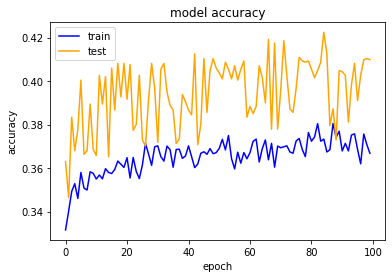

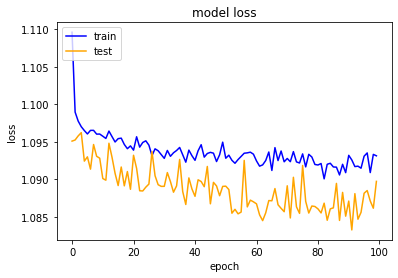

In [30]:
model_acc, history_acc = train_plot_cnn(x_train=X_train,
                           y_train=Y_train,
                           metric='accuracy',
                           batch_size=64,
                           epochs=100)